In [28]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import F1Score
import unicodedata
import spacy
import re
import matplotlib.pyplot as plt
nltk.download('punkt')
import random
import os

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natedrake7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pre-Processing

In [47]:
#Read csv files
train_set = pd.read_csv('./Data/train_set.csv')
valid_set = pd.read_csv('./Data/valid_set.csv')
test_set = pd.read_csv('./Data/test_set.csv')



#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
valid_set = valid_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=['Party'])

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
valid_set['Text'] = valid_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'#', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'#', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'#', '', x))

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
valid_set['Text'] = valid_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
valid_set['Text'] = valid_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
valid_set['Text'] = valid_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
valid_set['Text'] = valid_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
valid_set['Text'] = valid_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)

Save Pre-Processed Data

In [48]:
train_set.to_csv('processed_df',index=False)
valid_set.to_csv('processed_valid',index=False)
test_set.to_csv('processed_test',index=False)

Load Pre-Processed Data

In [3]:
train_set = pd.read_csv('processed_df')

test_set = pd.read_csv('processed_test')

valid_set = pd.read_csv('processed_valid')

Tokenize Text and create W2V Model

In [50]:
#Tokenize text so word2vec can utilize it
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

#Create Word2Vec models
model = Word2Vec(sentences=train_set['Tokenized_Text'], vector_size=300,window=5,min_count=2,negative = 10)

#Train the model
model.train(train_set['Tokenized_Text'], total_examples= len(train_set['Text']), epochs=30)

#Save the model
model.save("./Data/word2vec_new.model")

Load self-trained Word2Vec Model

In [4]:
word2vec_model = Word2Vec.load('./Data/word2vec_new.model')

Tokenize Texts

In [5]:
#Tokenize all texts
valid_set['Tokenized_Text'] = valid_set['Text'].apply(lambda x: word_tokenize(x))
test_set['Tokenized_Text'] = test_set['Text'].apply(lambda x: word_tokenize(x))
train_set['Tokenized_Text'] = train_set['Text'].apply(lambda x: word_tokenize(x))

In [6]:
print(word2vec_model.wv.most_similar('μητσοτακης'))

[('Μητσοτακης', 0.5086226463317871), ('συρρικνωσει', 0.36148396134376526), ('μεγαλοεπιχειρηματιος', 0.3526388108730316), ('λουτσεσκος', 0.3467840254306793), ('προχωρησει', 0.34266385436058044), ('φορων', 0.3384942412376404), ('μητσοτακη', 0.3345755338668823), ('μανταρα', 0.32649001479148865), ('αγνοησει', 0.31639620661735535), ('περικοπω', 0.31446248292922974)]


Encode Labels

In [7]:
encoder  = LabelEncoder() #initialize label encoder so we can set integer values to the label unique values

X_train_labels = encoder.fit_transform(train_set['Sentiment']) #Transform the labels
X_valid_labels = encoder.fit_transform(valid_set['Sentiment']) #For both training and validation

print(encoder.classes_)
print(encoder.transform(encoder.classes_))
labels = {0 : 'NEGATIVE',1 : 'NEUTRAL',2 : 'POSITIVE'}

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
[0 1 2]


Create Dictionary

In [8]:
dictionary = word2vec_model.wv.key_to_index
print(dictionary)

{'ο': 0, 'τσιπρα': 1, 'μου': 2, 'νδ': 3, 'μητσοτακη': 4, 'σε': 5, 'εκλογος': 6, 'εχω': 7, 'συριζα': 8, 'συριζας': 9, 'κκε': 10, '2019': 11, 'σκαι': 12, 'εγώ': 13, 'μητσοτακης': 14, 'ένας': 15, 'κιναλ': 16, 'γιατι': 17, 'εκλογες2019': 18, 'κανω': 19, 'αλεξη': 20, 'ηταν': 21, 'νεα': 22, 'πασοκς': 23, 'μπορω': 24, 'συνεντευξη': 25, 'ελλαδα': 26, 'οχι': 27, 'σου': 28, 'τωρας': 29, 'ολος': 30, 'τσιπρο': 31, 'κυβερνηση': 32, '1': 33, '2': 34, 'τελος': 35, 'γεννηματα': 36, 'θελω': 37, 'πολιτικος': 38, 'χωρα': 39, 'οταν': 40, 'λεει': 41, 'αλλος': 42, 'ολα': 43, 'μονος': 44, 'ουτε': 45, 'ρε': 46, '7': 47, 'ξεφτιλες': 48, 'κυριακος': 49, 'σημερα': 50, 'οπως': 51, 'ερχεται': 52, 'πολυ': 53, '5': 54, 'μεσω': 55, 'φωφη': 56, 'υπαρχω': 57, '4': 58, 'πιο': 59, 'εγω': 60, 'ως': 61, 'κουλη': 62, '3': 63, 'βαρουφακη': 64, 'ψηφος': 65, 'υποψηφιος': 66, 'εδω': 67, 'κυριακη': 68, 'ειπες': 69, 'πρεπει': 70, 'α': 71, 'βουλη': 72, 'ενο': 73, 'πασοκ': 74, 'γινω': 75, 'κομμα': 76, 'ψηφιζω': 77, 'ενα': 78, 'δημο

Create Embedding Matrix

In [9]:
embedding_matrix = np.zeros((len(dictionary), 300))

for word,i in dictionary.items():
    embedding_matrix[i] = word2vec_model.wv[word]

Convert Tweets to Vectors

In [10]:
def ConvertTextToIndices(text):
    indices = []
    for sentence in text:
        sentence_indices = []
        for word in sentence:
            if word in dictionary:
                sentence_indices.append(dictionary[word])
        indices.append(sentence_indices)
    return indices

wordvec_train_indices = ConvertTextToIndices(train_set['Tokenized_Text']) #Convert all tweets to vectors
wordvec_valid_indices = ConvertTextToIndices(valid_set['Tokenized_Text'])#By finding the mean of all the vectors
wordvec_test_indices = ConvertTextToIndices(test_set['Tokenized_Text'])#Of all the words in each tweet



Check Shape

In [11]:
len(wordvec_train_indices)

36630

Find the maximun length of a sentence in all 3 Datasets

In [12]:
max_length = 0

for i,row in enumerate(wordvec_train_indices):
    train_row_length = len(row)
    if i < len(wordvec_test_indices):
        test_row_length = len(wordvec_test_indices[i])
    if i < len(wordvec_valid_indices):
        valid_row_length = len(wordvec_valid_indices[i])
    # Update max_length if the current row's length is greater
    if train_row_length > max_length:
        max_length = train_row_length
    if test_row_length > max_length:
        max_length = test_row_length
    if valid_row_length > max_length:
        max_length = valid_row_length

print(max_length)

58


Convert List To Tensors

In [13]:
wordvec_train_indices = [torch.LongTensor(seq) for seq in wordvec_train_indices]
wordvec_valid_indices = [torch.LongTensor(seq) for seq in wordvec_valid_indices]
wordvec_test_indices = [torch.LongTensor(seq) for seq in wordvec_test_indices]

Configure Max length for each List of indices

In [14]:
wordvec_train_indices[0] = nn.ConstantPad1d((0, max_length - wordvec_train_indices[0].shape[0]), 0)(wordvec_train_indices[0])
wordvec_valid_indices[0] = nn.ConstantPad1d((0, max_length - wordvec_valid_indices[0].shape[0]), 0)(wordvec_valid_indices[0])
wordvec_test_indices[0] = nn.ConstantPad1d((0, max_length - wordvec_test_indices[0].shape[0]), 0)(wordvec_test_indices[0])


Create Tensorflow tensors

In [15]:
batch_size = 128
#Train set
X_train_tensor = pad_sequence(wordvec_train_indices, batch_first=True, padding_value=0)
Labels_train_tensor = torch.tensor(X_train_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_train_tensor,Labels_train_tensor) #Create a dataset
Train_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the train set


#Val set
X_val_tensor = pad_sequence(wordvec_valid_indices, batch_first=True, padding_value=0)
Labels_val_tensor = torch.tensor(X_valid_labels,dtype=torch.long) #create a torch tensor for the labels from the numpy array
Dataset = TensorDataset(X_val_tensor,Labels_val_tensor) #Create a dataset
Validation_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the validation set


X_test_tensor = pad_sequence(wordvec_test_indices, batch_first=True, padding_value=0)
Dataset = TensorDataset(X_test_tensor) #Create a dataset
Test_set = DataLoader(Dataset,batch_size=batch_size,shuffle=True) #Create the test set

Set Gpu Or Cpu

In [16]:
if torch.cuda.is_available(): #if nvidia gpu is available
   device="cuda" #set devide to cuda since GPUs are much faster at deep learning
else: 
   device="cpu" #else set CPU
print("Device =",device)

Device = cuda


Recurrent Neural Network

In [21]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, embedding_matrix):
        super(RNN, self).__init__()

        cells = {
            "RNN" : nn.RNN,
            "LSTM" : nn.LSTM,
            "GRU" : nn.GRU
        }

        self.cell_type = cell_type
        self.embedding_matrix = embedding_matrix
        self.embedding_dim = embedding_matrix.shape[1]  # Assuming the embedding matrix has been pre-computed

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)

        self.rnn = cells[cell_type](
            input_size=self.embedding_dim,  # Input size is now the size of the embedding vectors
            hidden_size=hidden_size,
            batch_first=True
        )

        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, time_step), where time_step represents the length of each sequence

        embedded = self.embedding(x)  # Look up the embeddings for the input sequences

        # For RNN and GRU
        if self.cell_type != 'LSTM':
            r_out, h_n = self.rnn(embedded)

        # For LSTM
        else:
            r_out, (h_n, h_c) = self.rnn(embedded)

        # Output from the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [31]:
input_size = max_length
hidden_size = 64
output_size = 3
cell_type = 'LSTM'
net = RNN(cell_type, input_size, hidden_size, output_size,embedding_matrix).to(device)
print(net)

RNN(
  (embedding): Embedding(21946, 300)
  (rnn): LSTM(300, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=3, bias=True)
)


In [36]:
EPOCH = 10
LR = 0.01

optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters
loss_func = nn.CrossEntropyLoss()

Optimization using Optuna

Best F1-Score: 0.163906



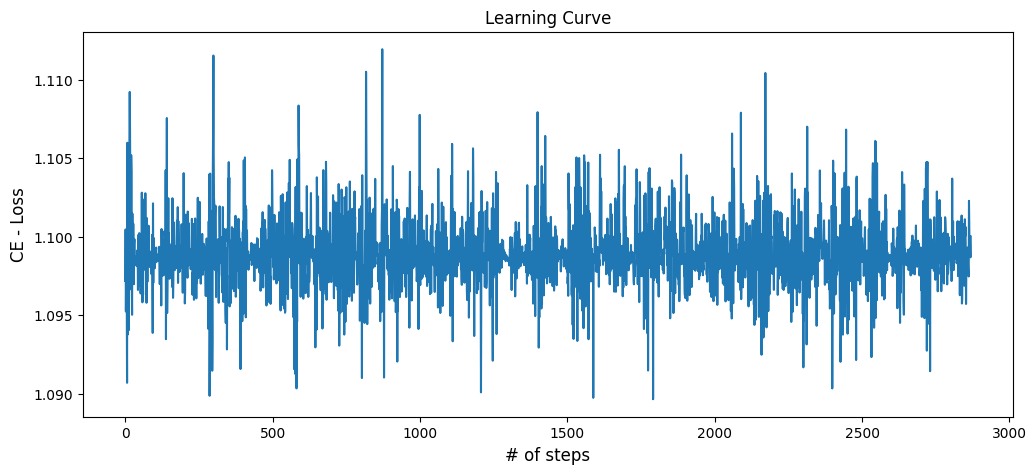

In [38]:
# Start train mode
net.train()

# Accumulate losses
losses = []
best_f1 = 0
# Count the number of batches given to the model

# Iterate over the whole dataset for one epoch
for epoch in range(EPOCH):
    torch.cuda.synchronize()
    f1 = 0
    step_count = 0
    f1_score = F1Score(task='multiclass',num_classes=3,average='weighted').to(device)

    # Generate batch data
    for step, (x, y) in enumerate(Train_set):

        # Move input data to the GPU
        x, y = x.to(device), y.to(device)

        # clear gradients for this training step
        optimizer.zero_grad()

        output = net(x)
        loss = loss_func(output, y)

        # For visualization
        losses.append(loss.item())
        f1 += f1_score(output.argmax(1), y)  # calculate the f1 score
        step_count += 1

        # backpropagation - compute gradients
        loss.backward()

        # apply gradients
        optimizer.step()

    f1 /= step_count

    if f1 >= best_f1:
        best_f1 = f1

print(f"Best F1-Score: {f1:>8f}\n")  # print statistics

# Plot results
plt.figure(figsize=(12,5))
plt.plot(losses)
plt.title('Learning Curve')
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

In [63]:
Predictions = []

with torch.no_grad(): #disable gradient caclulation since we are testing not training
    for X in Test_set:
        X = X[0].to(device) #Load to GPU

        #pred = new_best_model(X) #predict the label
        #Predictions.append(pred.argmax(1).cpu().numpy())

Predictions = np.concatenate(Predictions)

In [64]:
#Create a dataframe based on a dictionary of the IDs and the predictions
y_test = pd.DataFrame(data={'Id': test_set['New_ID'], 'Predicted': Predictions})

#Convert the predicted labels [0,1,2] back to their corresponding labels [NEGATIVE,NEUTRAL,POSITIVE]
y_test['Predicted'] = y_test['Predicted'].apply(lambda x: labels.get(x,x))

#Save as csv
y_test.to_csv('sumbission.csv',index=False)

Number of epochs not enough for model to learn,increase to 10,then 20 and then 30